# Import libraries

In [1]:
%%capture --no-display
import os, random 
import numpy as np
from simulation import Simulation
from connectome import Connectome
from utility import are_signals_similar

# Init data saving folder:
SAVE_FOLDER = './result/res'
ROOT_FOLDER = os.getcwd()
try:
    os.listdir(SAVE_FOLDER)
except:
    os.mkdir(SAVE_FOLDER)

# Task 1: Simulating sequential auditory inputs in A1

### Initialise and run the simulation in A1_R with 4 different stimulus strength

In [2]:
# Import connectome
connectivity_path = ROOT_FOLDER + '/tvb_model_reference/data/macaque/Connectivity/'
connectome = Connectome(connectivity_path)

sim_series1_param = {"root_folder": SAVE_FOLDER,
                     "sim_name": "simAl", #Name of the simulation
                     "connectome_instance": connectome, #Load the connectome to change
                     "rois_stim_values": {'A1_R': [0.001, 0.405, 0.41, 2]}, #Stimulus Regions
                     "isIntNoise": False}

# Create and init a simulator object
SimSeries1 = Simulation(**sim_series1_param)

# Run the simulation
# SimSeries1.main_simulation_loop() 

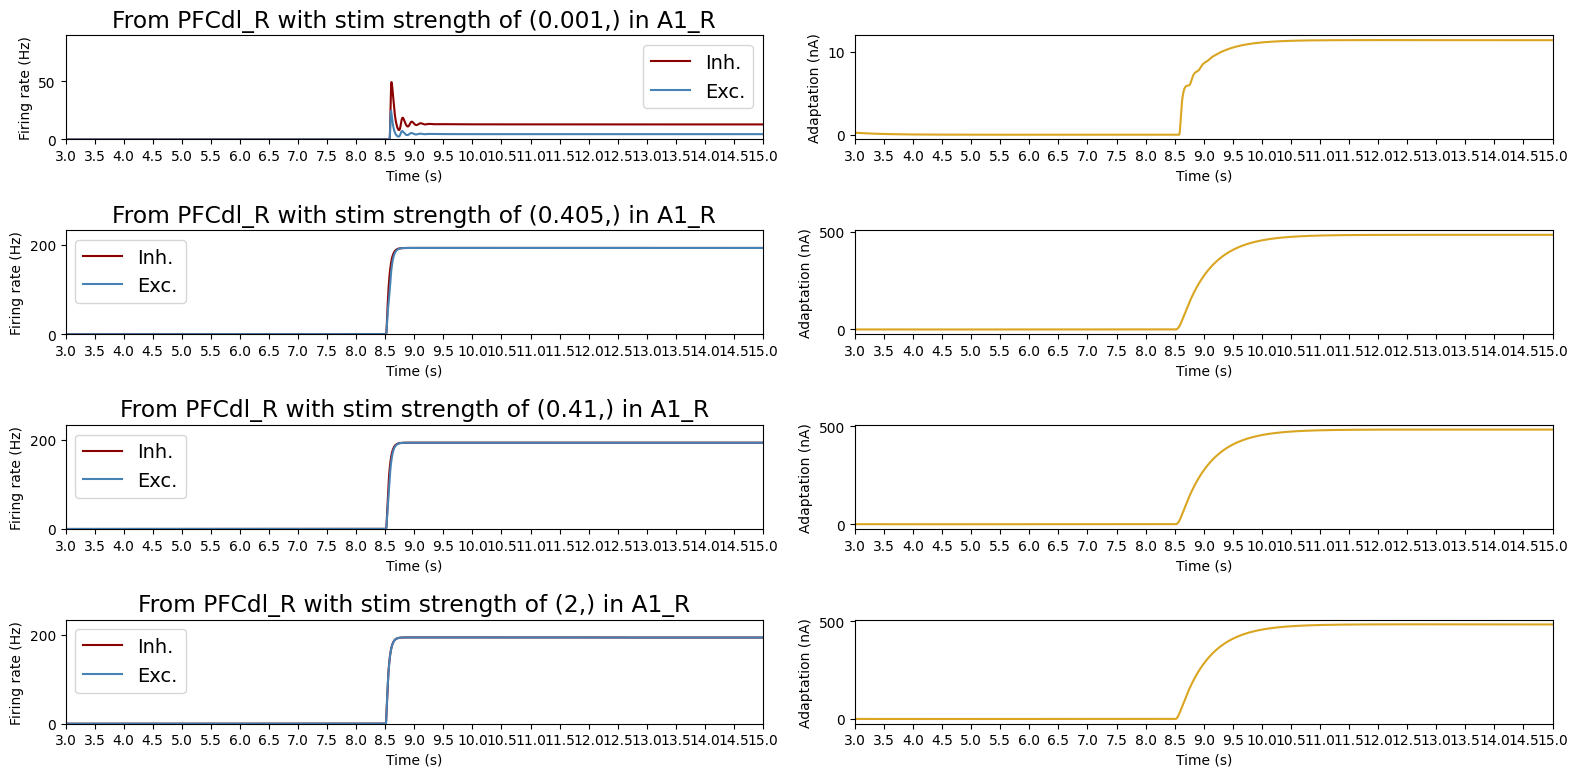

In [3]:
# Load simulation saved results
SimSeries1.load_simulation() 

# # PFCdl_R plot from A1
SimSeries1.plot_simulation(['PFCdl_R']) 

### Load and output 4 plots (one for each strimulus strength)

# 2) Comparative Analysis of PFCdl Outputs using MSE

### Compute MSE (Mean Square Error) of each 4 simulations to define a threshold

In [4]:
# signals_dict contains 4 signals each resulted from Sim1 with a different stimval
signals_dict = SimSeries1.get_inh_signals_from_region(['PFCdl_R'])

stimvals = sim_series1_param["rois_stim_values"]["A1_R"]

signal0 = signals_dict[stimvals[0]] # with stimval = 0.001
signal1 = signals_dict[stimvals[1]] # with stimval = 0.405
signal2 = signals_dict[stimvals[2]] # with stimval = 0.41
signal3 = signals_dict[stimvals[3]] # with stimval = 2

are_signals_similar(signal0, signal1)
are_signals_similar(signal2, signal3)
are_signals_similar(signal1, signal2)
are_signals_similar(signal0, signal3)

MSE: 34.574663777510715
MSE: 2.733403337791166
MSE: 91.21913761853249
MSE: 123.35349977942418


# 3) Testing: 2 different types of simulation in M1 (i.e Type1 or Type2) whether inputs are similar or not

In [5]:
def random_signal_picker(dict_of_signal, verbose = False):
    '''
    Return two time series randomly picked from dict_of_signal.
    
    param dict_of_signal (dict): contains timeseries of inh firing rates as values and their stimval as keys.
    param verbose (bool): True to print verbose.
    '''
    # Select two random stimvals from signals_dict
    stimvals = random.sample(list(dict_of_signal.keys()), 2)
    # Get the time series associated with the selected stimvals
    if verbose : 
        print(f"Signals with stimval = {stimvals[0]} and {stimvals[1]} have been randomly selected")
    return dict_of_signal[stimvals[0]], dict_of_signal[stimvals[1]]


def press_button(stim_region, stimval, plot_taget_area, exp_name = ""):
    '''
    Run a simulation with a given stimulus target region and stimval.
    
    param stim_region (dict): dictionnary of regions of interest where to input the stimulus.
    param stimval (list): list of stimulus strength.
    plot_target_area (str): Name of the target area to plot.
    param exp_name (str): experiment name.
    '''
    button_sim_param = {"root_folder": SAVE_FOLDER,
                        "sim_name": f"sim_temp{exp_name}", #Name of the simulation
                        "connectome_instance": connectome, #Load the surface/connectome to change
                        "rois_dict": stim_region, #Stimulus Regions
                        "stim_values": stimval, # Stimulus strengths
                        "isIntNoise": False}

    # Create and initialize the simulator with M1 as stimulus region
    SimTemp = Simulation(**button_sim_param)
    SimTemp.main_simulation_loop() # Run simulation
    SimTemp.load_simulation() # Load simulation
    SimTemp.plot_simulation(plot_taget_area) # M1 plots


def take_decision(signal1, signal2, threshold = 0):
    '''
    MSE-based thresholder that acts as a decision maker.
    Return either [0.001] or [0.02] whether signal1 and signal2 are similar or not.
    [0.001] and [0.02] corresponds to 2 diff stimvals.
    
    param signal1 ([]): time-serie of inh firing rates with a given a stimval.
    param signal2 ([]): another time-serie of inh firing rates with a given a stimval.
    param thresh (int): MSE-based threshold to differentiate S1 from S2.
    '''
    # Determine stimval in M1 based on time series similarity
    return [0.001] if are_signals_similar(signal1, signal2, threshold) else [0.02]

In [6]:
# Define where to apply the stimulus.
motor_stim_region = {'M1_R': 'Primary motor area'} 
plot_area = ["M1_R"]

task_nb = 2 # Run a set of 2 comparison tasks.

for i in range(1, task_nb+1):
    input_signal1, input_signal2 = random_signal_picker(signals_dict, verbose = True)
    stimval_M1 = take_decision(input_signal1, input_signal2, threshold = 60)
    press_button(motor_stim_region, stimval_M1, plot_area, exp_name = str(i))

Signals with stimval = 2 and 0.41 have been randomly selected


TypeError: Simulation.__init__() got an unexpected keyword argument 'rois_dict'

# Case 2: with 2 cortical cols in A1_R and PFCdl_R

### Edit the connectome to create 2 corticals in the form of [A1_Ra, A1_Rb] and [PFCdl_Ra, PFCdl_Rb] to simulate simultaneous S1 and S2 inputs.

In [4]:
# Import connectome
connectome = Connectome(connectivity_path)

new_connectivity_file_name = "Conn_case2"
new_connectivity_path = ROOT_FOLDER + f'/tvb_model_reference/data/macaque/{new_connectivity_file_name}/'

connectome.duplicate_region('A1_R') #cross and auto corr are equally weighted 
connectome.duplicate_region('PFCdl_R') 

# Set Cross-weight to 0 i.e [A1_Ra, PFCdl_Rb] and [A1_Rb, PFCdl_Ra]
connectome.set_weight('A1_Ra', 'PFCdl_Rb', 0)
connectome.set_weight('A1_Rb', 'PFCdl_Ra', 0)

# Save the edited connectome
connectome.save_changes(new_connectivity_path)

### Run simulation at A1_Ra and A1_Rb

In [5]:
new_connectome = Connectome(new_connectivity_path)
sim_series2_param = {"root_folder": SAVE_FOLDER,
                     "sim_name": "simCl", #Name of the simulation
                     "connectome_instance": new_connectome, #Load the surface/connectome to change
                     "rois_stim_values": {'A1_Ra': [0.001],
                                   'A1_Rb': [2]}, #Stimulus Regions
                     "isIntNoise": False}

# Create and init a simulator object
SimSeries2 = Simulation(**sim_series2_param)

# Run the simulation
#SimSeries2.main_simulation_loop()

### Load results and plot outputs from the two corticals of PFCdl

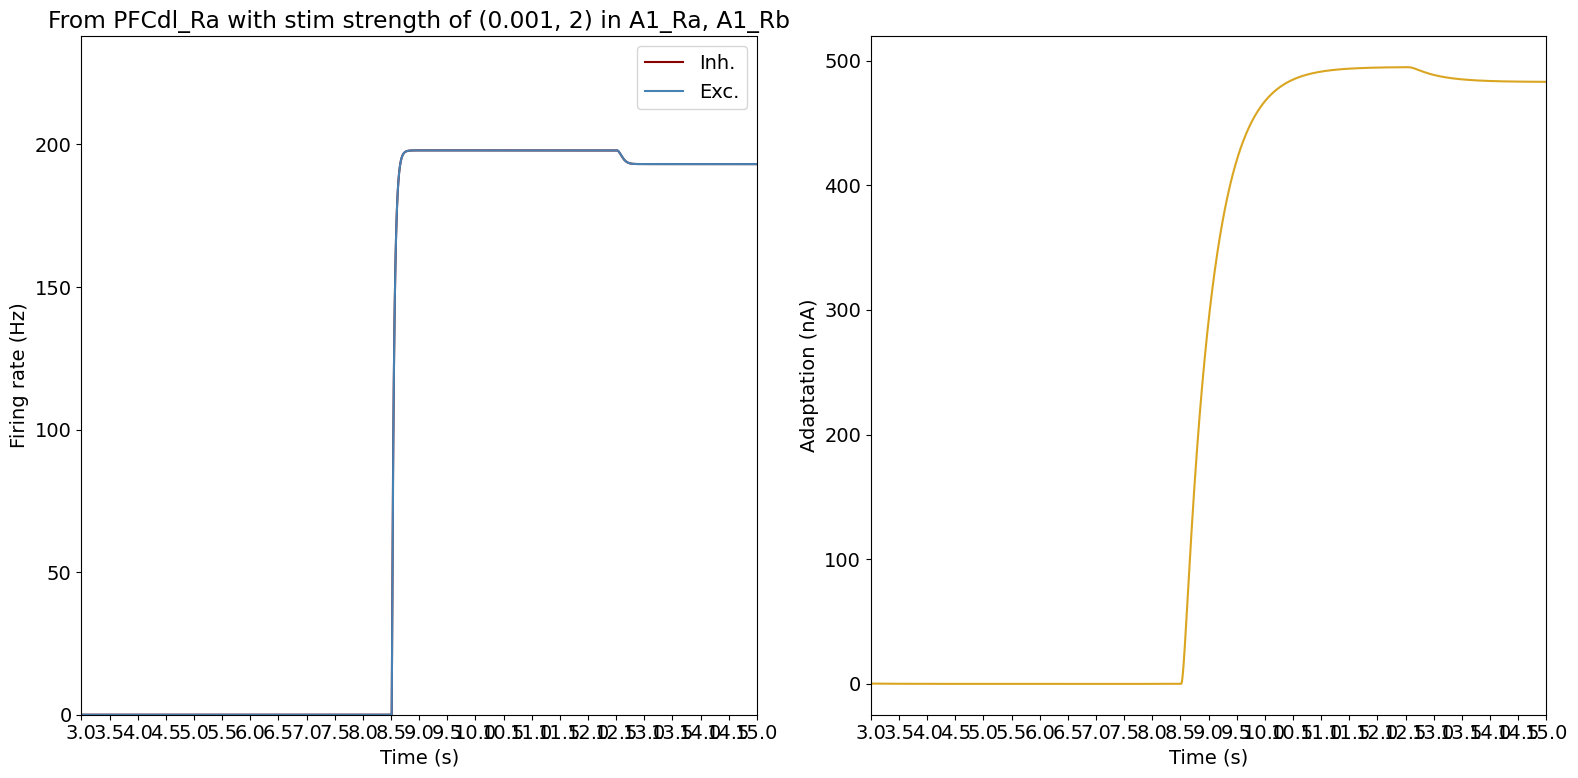

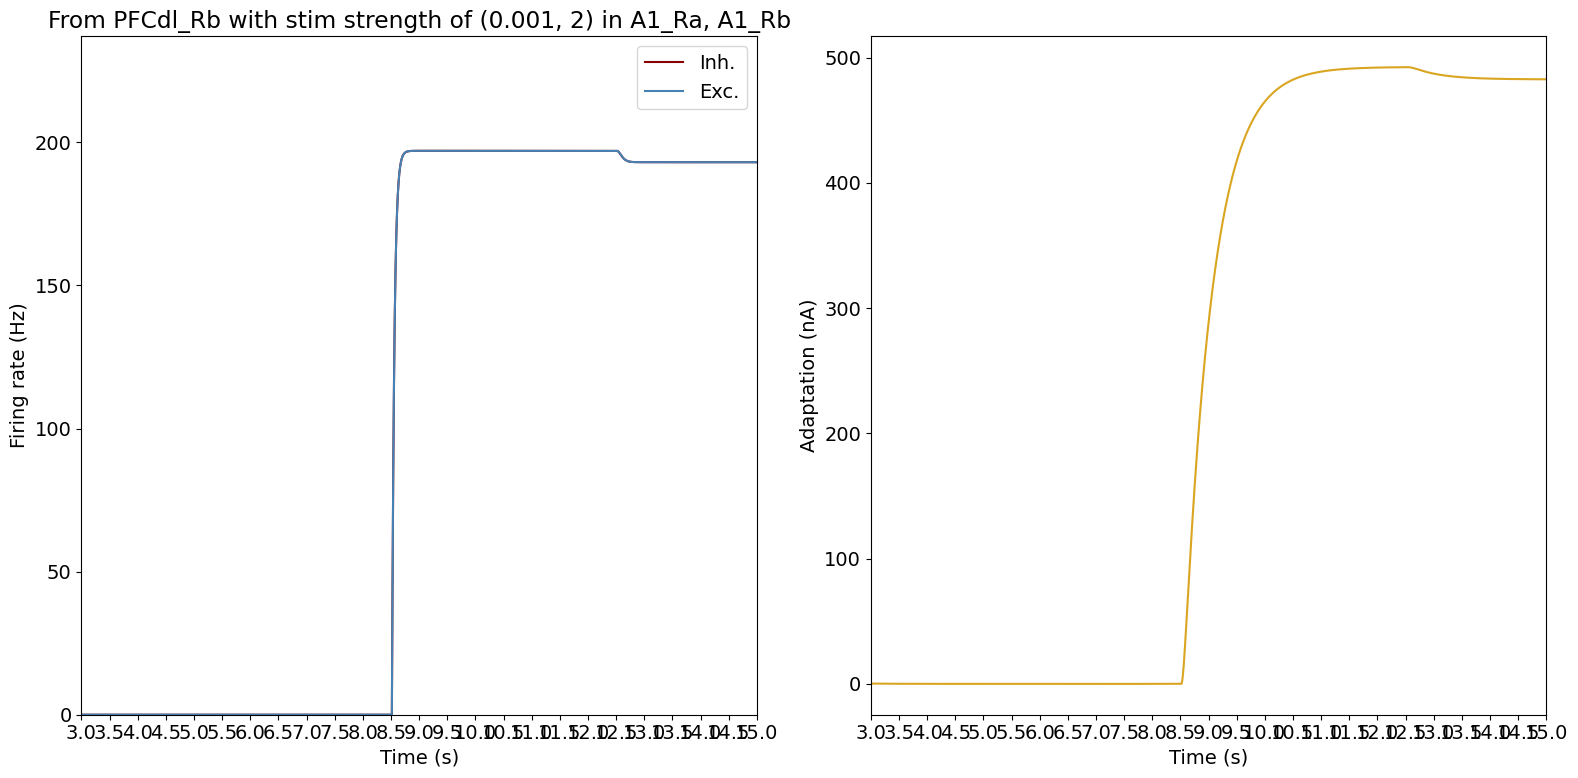

In [6]:
SimSeries2.load_simulation() # Load simulation
SimSeries2.plot_simulation(['PFCdl_Ra'])
SimSeries2.plot_simulation(['PFCdl_Rb'])

### Same output => New sim with increasing auto-corr and decreasing cross-corr weights

In [9]:
# Import connectome
connectome = Connectome(connectivity_path)

conn_autocorr_name = "Conn_case3"
conn_autocorr_path = ROOT_FOLDER + f'/tvb_model_reference/data/macaque/{conn_autocorr_name}/'

connectome.duplicate_region('A1_R', 0.9) #auto-corr has %90 of the overall weight, cross => %10
connectome.duplicate_region('PFCdl_R', 0.9) 

# Set Cross-weight to 0 i.e [A1_Ra, PFCdl_Rb] and [A1_Rb, PFCdl_Ra]
connectome.set_weight('A1_Ra', 'PFCdl_Rb', 0)
connectome.set_weight('A1_Rb', 'PFCdl_Ra', 0)

# Save the edited connectome
connectome.save_changes(conn_autocorr_path)

In [10]:
conn_autocorr = Connectome(conn_autocorr_path)
sim_series3_param = {"root_folder": SAVE_FOLDER,
                     "sim_name": "simCl", #Name of the simulation
                     "connectome_instance": conn_autocorr, #Load the surface/connectome to change
                     "rois_stim_values": {'A1_Ra': [0.001],
                                   'A1_Rb': [2]}, #Stimulus Regions
                     "isIntNoise": False}

# Create and init a simulator object
SimSeries3 = Simulation(**sim_series3_param)

# Run the simulation
SimSeries3.main_simulation_loop()

||||||||||||||||||||||||||||||||||||||
SimNb: 0
ROI/Stimval: {'A1_Ra': 0.001, 'A1_Rb': 2}
simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
simulation time :6000.0
simulation time :7000.0
simulation time :8000.0
simulation time :9000.0
simulation time :10000.0
simulation time :11000.0
simulation time :12000.0
simulation time :13000.0
simulation time :14000.0
simulation time :15000.0
Simulation took 171.19 seconds to complete.


### Load results and plot outputs from the two corticals of PFCdl

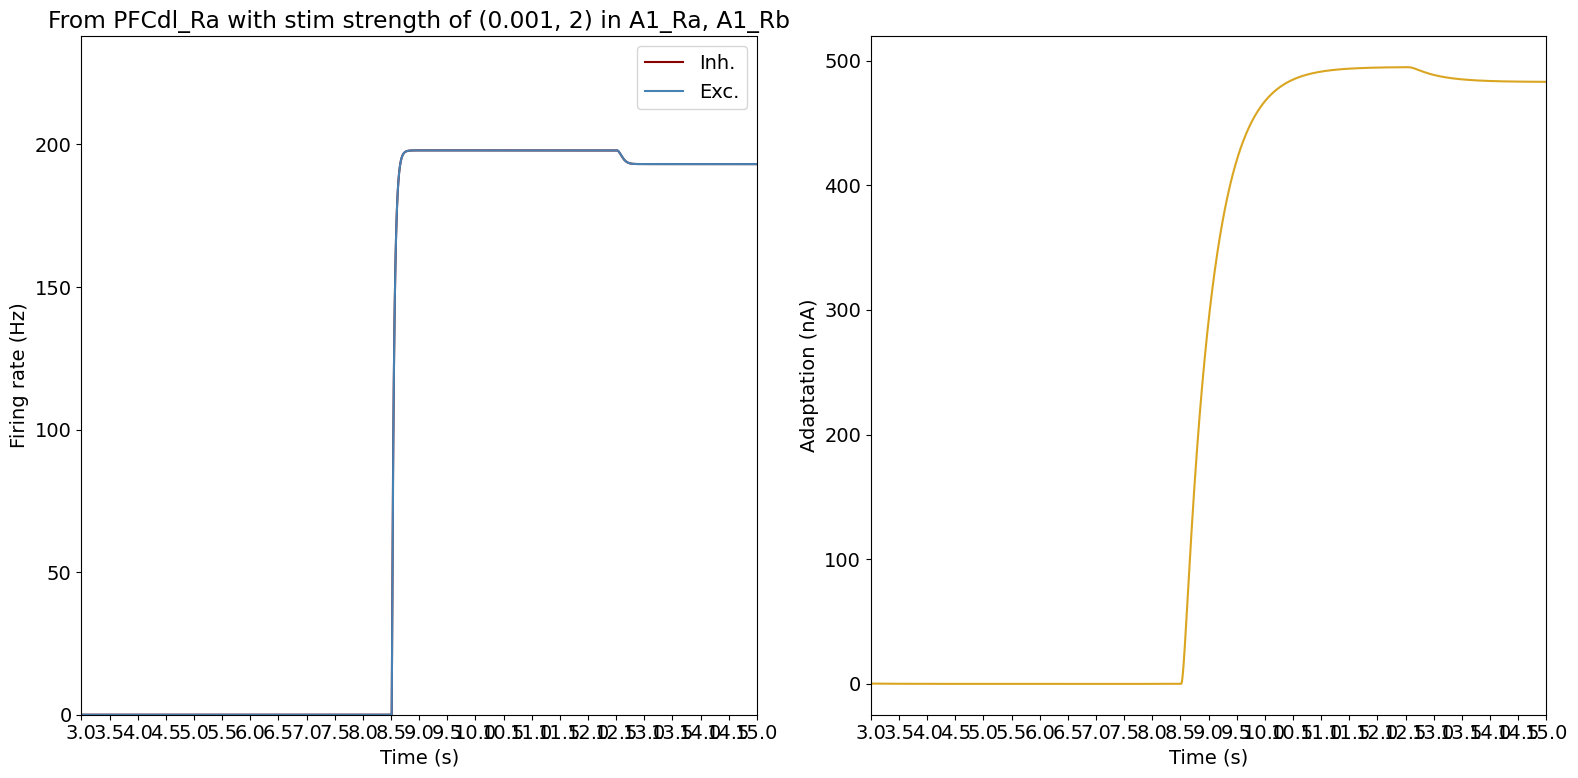

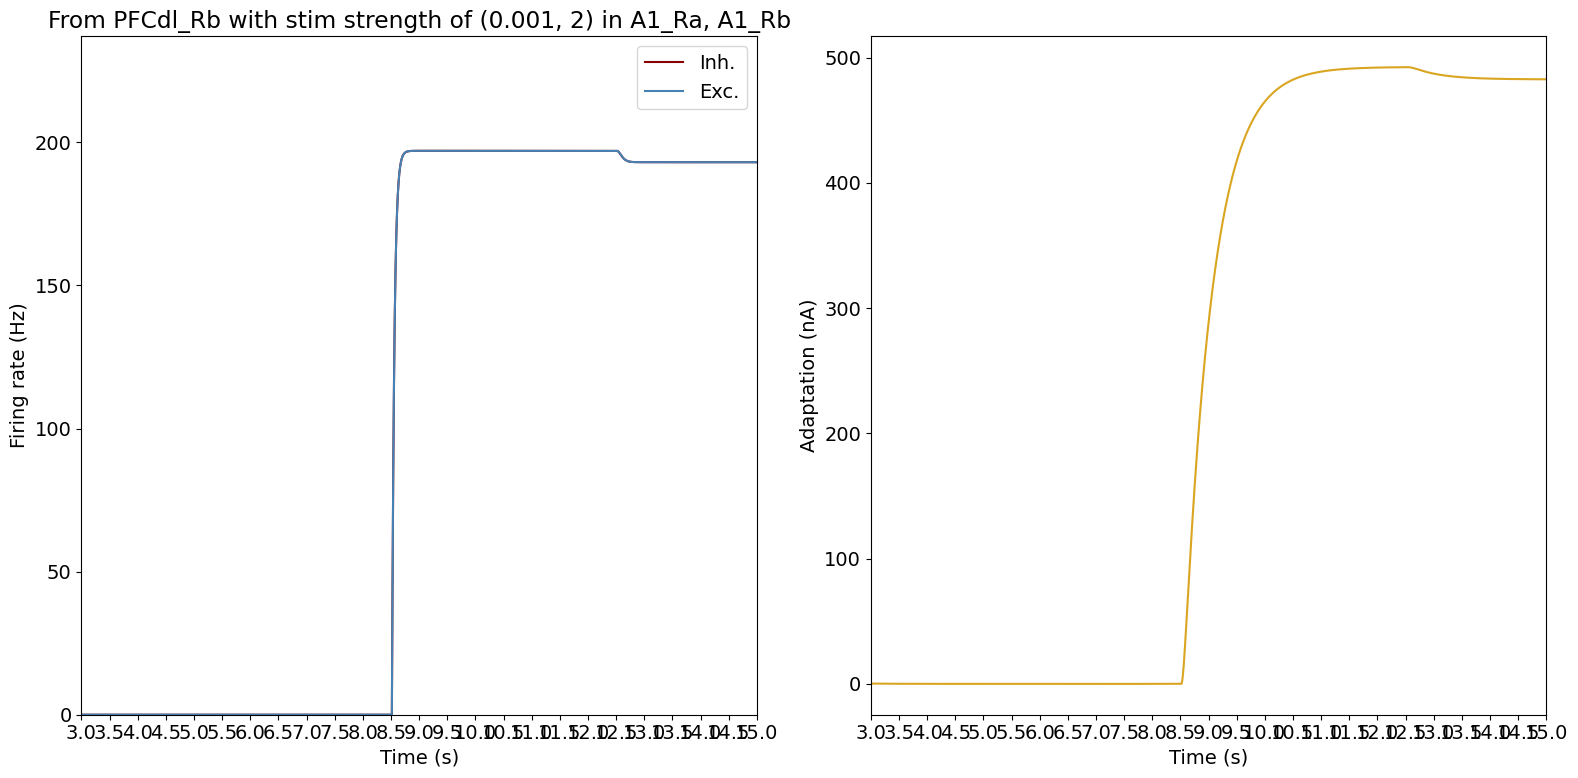

In [11]:
SimSeries3.load_simulation() # Load simulation
SimSeries3.plot_simulation(['PFCdl_Ra']) 
SimSeries3.plot_simulation(['PFCdl_Rb'])

### Same outputs again